# Introduction


In this project, I implement image-to-image translation from human selfies to anime faces using CycleGan.

In [2]:
# Imports
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as T
from torchvision import datasets
import random
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image as I



## Data Preparation / Loading

In this section I create the Faces dataset for the real and anime selfies. I also pre-process the data by resizing each image to be 128x128, normalizing the input, and transforming it into a tensor. Resizing the image to be 128x128 was done to reduce computation time, and normalizing the input is a standard procedure in computer vision that can speed up training.

In [1]:
class FacesDataset(Dataset):
    def __init__(self, realFacesRoot, animeFacesRoot):
        self.realRoot = realFacesRoot
        self.animeRoot = animeFacesRoot
        self.realFaces = os.listdir(realFacesRoot)
        self.animeFaces = os.listdir(animeFacesRoot)
        self.realFacesSize = len(self.realFaces)
        self.animeFacesSize = len(self.animeFaces)

        self.lengthDataset = max(self.realFacesSize,self.animeFacesSize) # Should be the same
        
        self.transformations = A.Compose(
            [A.Resize(width=256, height=256),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
             ToTensorV2(),
            ],
            additional_targets={"image0": "image"})
        
    def __len__(self):
        return self.lengthDataset

    def __getitem__(self, index):
        realFace = self.realFaces[index % self.realFacesSize]
        animeFace = self.animeFaces[index % self.animeFacesSize]

        realFacePath = os.path.join(self.realRoot, realFace)
        animeFacePath = os.path.join(self.animeRoot, animeFace)

        realFace = np.array(I.open(realFacePath).convert("RGB"))
        animeFace = np.array(I.open(animeFacePath).convert("RGB"))
        transformedFaces= self.transform(image=realFace, image0=animeFace)

        realFace = transformedFaces["image0"]
        animeFace = transformedFaces["image"]

        return realFace, animeFace

NameError: name 'Dataset' is not defined

In [3]:
# Hyperparameters for the Loaders
BATCH_SIZE = 1
NUM_WORKERS = 4

# class Transforms:
#     def __init__(self):
#         self.transforms = A.Compose([
#             A.Resize(128,128),
#             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
#             ToTensorV2()])
        
#     def __call__(self, img, *args, **kwargs):
#         return self.transforms(image=np.array(img))['image']
# transformations = v2.Compose([
#     v2.Resize((128, 128)),
#     v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     v2.ToTensor()
# ])

facesDataset = FacesDataset("./data/trainA/realTrain", "./data/trainB/animeTrain")
_,facesDataset = random_split(facesDataset, [int(0.995 * len(facesDataset)), int(0.005 * len(facesDataset))])
print(len(facesDataset))

facesLoader = torch.utils.data.DataLoader(facesDataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
print(len(facesLoader))
print("HI!")
iterable = iter(facesLoader)

c:\Users\DK\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


17
17
HI!


# Visualization of Dataset

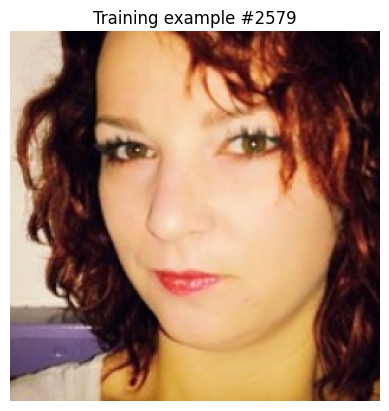

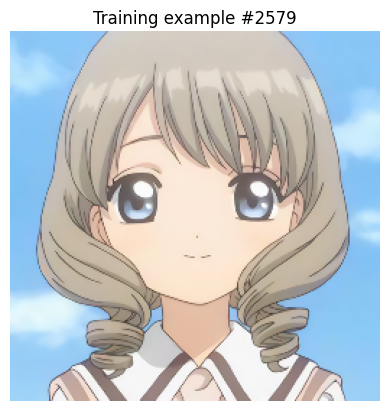

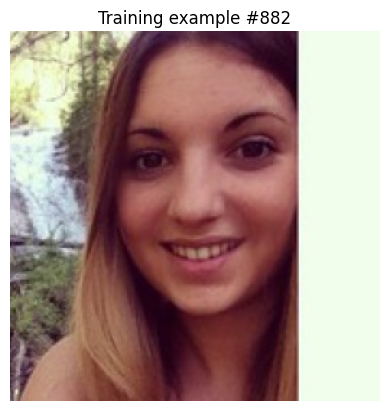

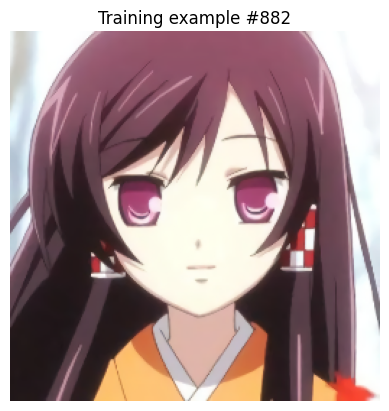

In [8]:
# Visualize a couple of images from the anime and face datasets
def visualize_samples(dataset, num_samples):
    for _ in range(num_samples):
        random_seg_img = random.randint(0, len(dataset) - 1)
        realFace, animeFace = dataset[random_seg_img]
        plt.imshow(realFace.permute(1, 2, 0))
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()
        plt.imshow(animeFace.permute(1, 2, 0))
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()
visualize_samples(facesDataset, 2)




# Constructing the Generative Model

In [5]:
# Generative Model
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.num_channels = num_channels
        self.single_residual_block = nn.Sequential(
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
            nn.ReLU(),
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
            nn.ReLU() # This could optionally be taken away?
        )
    def forward(self, x):
        return x + self.single_residual_block(x)

class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        
        # Downsampling layers
        self.downSampleLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect"),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels = 128, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels = 256, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )
        # At the end of downsampling, input is 32x32x256

        # 6 residual blocks, as recommended in the paper for 128 x 128 images
        self.residualLayers = nn.Sequential( # maybe should be module list?
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Upsampling layers
        self.upSampleLayers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        )
        # At the end of upsampling layers input is 128x128x64

        # Final layer, reverts back to 3 color channels. Output is 128x128x3
        self.out = nn.Conv2d(64, 3, 7, 1, 3, padding_mode= "reflect")

    def forward(self, x):
        x = self.downSampleLayers(x)
        x = self.residualLayers(x)
        x = self.upSampleLayers(x)
        x = self.out(x)
        return x
        

# Constructing the Discriminator Model

In [6]:
# Discriminative Model

class DiscriminativeModel(nn.Module):
    def __init__(self):
        super(DiscriminativeModel, self).__init__()
        
        # Discriminator Layers
        self.discriminatorLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            # No instance norm for the first layer, as the cycleGan paper suggests
            nn.LeakyReLU(0.2),
            # Output is 64x64x64

            nn.Conv2d(in_channels =64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            # Output is 32x32x128

            nn.Conv2d(in_channels =128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            # Output is 16x16x256

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            # Output is 8x8x512
        )

        self.out = nn.Sequential(
            nn.Conv2d(512, 1, 4,1,1, padding_mode="reflect"),
            nn.Sigmoid() 
        )
        # Results in a binary label

    def forward(self, x):
        x = self.discriminatorLayers(x)
        x = self.out(x)
        return x

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Save a model
def saveModel(model, optimizer, epochs, location):
    to_save = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "numEpochs": epochs
    }
    torch.save(to_save, location)

# Load a model
def loadModel(model, optimizer, lr, location):
    to_load = torch.load(location)
    model.load_state_dict(to_load["state_dict"])
    optimizer.load_state_dict(to_load["optimizer"])
    numEpochs = int(to_load["numEpochs"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return numEpochs

# Training

In [8]:
# Training
def train(facesLoader, genRealModel, genAnimeModel, discRealModel, discAnimeModel, genOpt, discOpt, genScaler, discScaler, lambdaVal = 10, epochs=100,  startingEpochs = 0):
    mseLoss = nn.MSELoss()
    l1Loss = nn.L1Loss()
    print(DEVICE)

    anime_originals = 0
    anime_fakes = 0
    
    genRealModel.train()
    genAnimeModel.train()
    discRealModel.train()
    discAnimeModel.train()
    
    for e in range(epochs):
        for idx, (realFace, animeFace) in enumerate(facesLoader):
            # animeFace = animeFace[0]
            # realFace = realFace[0]
            realFace = realFace.to(DEVICE)
            animeFace = animeFace.to(DEVICE)
            # Training discriminators
            with torch.cuda.amp.autocast():
                generatedAnimeFace = genAnimeModel(realFace)
                animeDiscOnGenerated = discAnimeModel(generatedAnimeFace.detach())
                animeDiscOnAnime = discAnimeModel(animeFace) 
                anime_originals += animeDiscOnAnime.mean().item()
                anime_fakes += animeDiscOnGenerated.mean().item()
                animeDiscOriginalLoss = mseLoss(animeDiscOnAnime, torch.ones_like(animeDiscOnAnime))
                animeDiscGeneratedLoss = mseLoss(animeDiscOnGenerated, torch.ones_like(animeDiscOnGenerated))
                animeDiscriminatorLoss = animeDiscOriginalLoss + animeDiscGeneratedLoss 

                generatedRealFace = genRealModel(animeFace)
                realDiscOnGenerated = discRealModel(generatedRealFace.detach()) 
                realDiscOnOriginal = discRealModel(realFace)
                realDiscOriginalLoss = mseLoss(realDiscOnOriginal, torch.ones_like(realDiscOnOriginal))
                realDiscGeneratedLoss = mseLoss(realDiscOnGenerated, torch.ones_like(realDiscOnGenerated))
                realDiscriminatorLoss = realDiscOriginalLoss + realDiscGeneratedLoss

                discriminatorLoss = (animeDiscriminatorLoss + realDiscriminatorLoss) / 2

            discOpt.zero_grad()
            discScaler.scale(discriminatorLoss).backward()
            discScaler.step(discOpt)
            discScaler.update()

            # Train generators
            with torch.cuda.amp.autocast():

                # Losses from discriminators
                discAnimeGenerated = discAnimeModel(generatedAnimeFace)
                discRealGenerated = discRealModel(generatedRealFace)
                lossGeneratedAnime = mseLoss(discAnimeGenerated, torch.ones_like(discAnimeGenerated))
                lossGeneratedReal = mseLoss(discRealGenerated, torch.ones_like(discRealGenerated))

                # Losses from cycling
                cycledAnimeFace = genAnimeModel(generatedRealFace)
                cycledRealFace = genRealModel(generatedAnimeFace)
                lossCycledAnimeFace = l1Loss(animeFace, cycledAnimeFace) * lambdaVal
                lossCycledRealFace = l1Loss(realFace, cycledRealFace) * lambdaVal

                generatorLoss = lossGeneratedAnime + lossGeneratedReal + lossCycledAnimeFace + lossCycledRealFace

            genOpt.zero_grad()
            genScaler.scale(generatorLoss).backward()
            genScaler.step(genOpt)
            genScaler.update()

            if idx % 250:
                print(f"Currently on epoch: {e + startingEpochs}, index: {idx}")

        saveModel(genRealModel, genOpt, e + startingEpochs, "savedModels/genRealModel")
        saveModel(genAnimeModel, genOpt, e + startingEpochs, "savedModels/genAnimeModel")
        saveModel(discRealModel, discOpt, e + startingEpochs, "savedModels/discRealModel")
        saveModel(discAnimeModel, discOpt, e + startingEpochs, "savedModels/discAnimeModel")
        print(f"SAVED EPOCH {e + startingEpochs} MODEL!")


In [9]:
SAVED_MODELS_EXIST = False

animeFaceGenerator = GeneratorModel().to(DEVICE)
realFaceGenerator = GeneratorModel().to(DEVICE)
animeFaceDiscriminator = DiscriminativeModel().to(DEVICE)
realFaceDiscriminator = DiscriminativeModel().to(DEVICE)

genOpt = optim.Adam(list(animeFaceGenerator.parameters()) + list(realFaceGenerator.parameters()), lr= 0.0002, betas = (0.9,0.999))
discOpt = optim.Adam(list(animeFaceDiscriminator.parameters()) + list(realFaceDiscriminator.parameters()), lr= 0.0002, betas = (0.9,0.999))

curNumEpochs = 0
if SAVED_MODELS_EXIST:
    curNumEpochs = loadModel(realFaceGenerator, genOpt, 0.0002, "savedModels/genRealModel")
    loadModel(animeFaceGenerator, genOpt, 0.0002, "savedModels/genAnimeModel")
    loadModel(realFaceDiscriminator, discOpt, 0.0002, "savedModels/discRealModel")
    loadModel(animeFaceDiscriminator, discOpt, 0.0002, "savedModels/discAnimeModel")
    print("LOADED SAVED MODELS")

genScaler = torch.cuda.amp.GradScaler()
discScaler = torch.cuda.amp.GradScaler()

train(facesLoader, realFaceGenerator, animeFaceGenerator, realFaceDiscriminator, animeFaceDiscriminator, genOpt, discOpt, genScaler, discScaler, startingEpochs = curNumEpochs)

# Visualizing Results

cuda:0
og face:
<built-in method cpu of Tensor object at 0x0000014C5B2A8B30>
generated face:
tensor([[[0.8018, 0.7923, 0.7922,  ..., 0.8728, 0.8990, 0.8921],
         [0.8009, 0.8152, 0.8052,  ..., 0.8714, 0.9058, 0.9091],
         [0.8032, 0.8262, 0.8312,  ..., 0.9149, 0.9249, 0.9221],
         ...,
         [0.3733, 0.3718, 0.3394,  ..., 1.0018, 1.0310, 1.0064],
         [0.3608, 0.3559, 0.3277,  ..., 0.9436, 0.9837, 0.9799],
         [0.3399, 0.3477, 0.3259,  ..., 0.9044, 0.9573, 0.9465]],

        [[0.7968, 0.7897, 0.7789,  ..., 0.8797, 0.9092, 0.9102],
         [0.7844, 0.8045, 0.7989,  ..., 0.8882, 0.9324, 0.9160],
         [0.8048, 0.8225, 0.8161,  ..., 0.9196, 0.9463, 0.9304],
         ...,
         [0.4320, 0.4353, 0.3767,  ..., 0.9083, 0.9445, 0.9165],
         [0.4157, 0.4169, 0.3750,  ..., 0.8586, 0.8940, 0.8892],
         [0.3995, 0.4075, 0.3584,  ..., 0.8283, 0.8769, 0.8621]],

        [[0.7862, 0.7689, 0.7529,  ..., 0.8657, 0.8873, 0.8714],
         [0.7857, 0.7938, 0.78

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


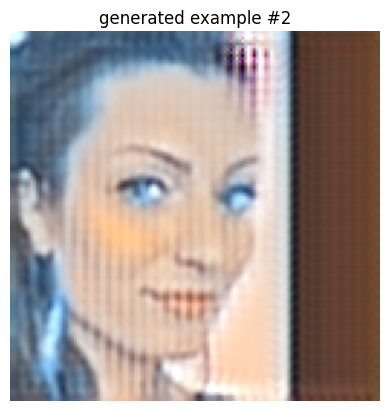

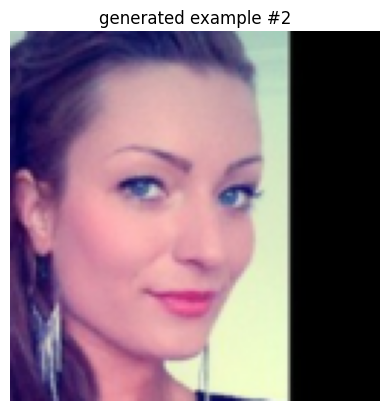

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


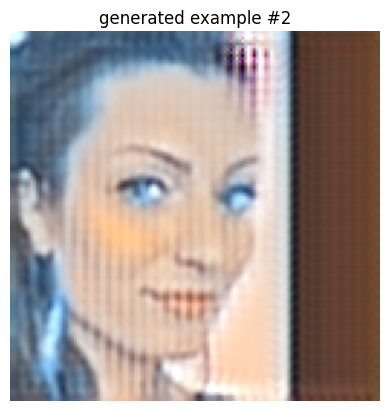

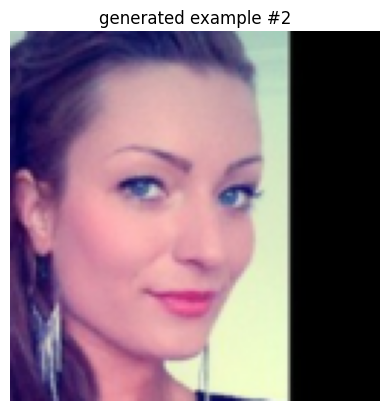

In [31]:
# Code to visualize results
def visualize_generated(listOfGenerated, num_samples):
    for _ in range(num_samples):
        random_seg_img = random.randint(0, len(listOfGenerated))
        generated, real = listOfGenerated[random_seg_img]
        plt.imshow(generated.permute(1, 2, 0))
        plt.title(f"generated example #{random_seg_img}")
        plt.axis('off')
        plt.show()
        plt.imshow(real.permute(1, 2, 0))
        plt.title(f"generated example #{random_seg_img}")
        plt.axis('off')
        plt.show()

print(DEVICE)
animeFaceGenerator = GeneratorModel().to(DEVICE)
genOpt = optim.Adam(list(animeFaceGenerator.parameters()) + list(realFaceGenerator.parameters()), lr= 0.0002, betas = (0.9,0.999))

loadModel(animeFaceGenerator, genOpt, 0.0002, "savedModels/genAnimeModel")

animeFaceGenerator.eval()
generatedAnimeFaces = []
for idx, (realFace, _) in enumerate(facesLoader):
    if idx % 10 == 0:
        realFace = realFace[0]
        realFace = realFace.to(DEVICE)
        generated_face = animeFaceGenerator(realFace)
        print("og face:")
        print(realFace.detach().cpu)
        generatedAnimeFaces.append((generated_face.detach().cpu(), realFace.detach().cpu()))
        print("generated face:")
        print(generated_face)
        
visualize_generated(generatedAnimeFaces, 2)
